# Credit card fraud detection

#### This notebook will test different methods on skewed data. The idea is to compare if preprocessing techniques work better when there is an overwhelming majority class that can disrupt the efficiency of our predictive model.

#### You will also be able to see how to apply cross validation for hyperparameter tuning on different classification models. My intention is to create models using:
1. Logistic Regression

In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Loading the dataset

In [2]:
data = pd.read_csv("https://s3-us-west-1.amazonaws.com/blackhat-us-2017/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Checking the target classes

Text(0, 0.5, 'Frequency')

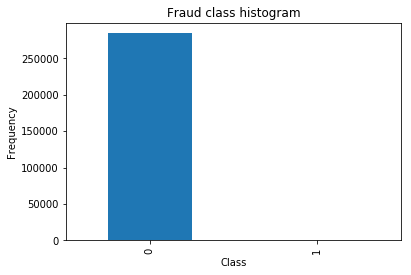

In [3]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

### Clearly the data is totally unbalanced!! 

#### This is a clear example where using a typical accuracy score to evaluate our classification algorithm. For example, if we just used a majority class to assign values to all records, we will still be having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!

#### There are several ways to approach this classification problem taking into consideration this unbalance. 

- Collect more data? Nice strategy but not applicable in this case
- Changing the performance metric:
    - Use the confusio nmatrix to calculate Precision, Recall
    - F1score (weighted average of precision recall)
    - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
    - ROC curves - calculates sensitivity/specificity ratio.
- Resampling the dataset
    - Essentially this is a method that will process the data to have an approximate 50-50 ratio.
    - One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
    - Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

# Approach

1. We are not going to perform feature engineering in first instance. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount). 
2. We will then compare what happens when using resampling and when not using it. We will test this approach using a simple logistic regression classifier.
3. We will evaluate the models by using some of the performance metrics mentioned above.
4. We will repeat the best resampling/not resampling method, by tuning the parameters in the logistic regression classifier.
5. We will finally perform classifications model using other classification algorithms.

# Setting our input and target variables + resampling.

#### 1. Normalising the amount column. The amount column is not in line with the anonimised features.

In [4]:
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


#### 2. Resampling.

- As we mentioned earlier, there are several ways to resample skewed data. Apart from under and over sampling, there is a very popular approach called SMOTE (Synthetic Minority Over-Sampling Technique), which is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

- In this notebook, we will use traditional UNDER-sampling.

- The way we will under sample the dataset will be by creating a 50/50 ratio. This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of records with the minority class.

In [5]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [6]:
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/float(len(under_sample_data)))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/float(len(under_sample_data)))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


# Splitting data into train and test set. Cross validation will be used when calculating accuracies.

In [7]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))


Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


# Logistic regression classifier - Undersampled data

#### We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

#### As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.
- Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite. 
- We could even apply a cost function when having FN and FP with different weights for each type of error, but let's leave that aside for now.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

#### Very ad-hoc function to print K_fold_scores

In [9]:
c_param_range = [0.01,0.1,1,10,100]

#print("# Tuning hyper-parameters for %s" % score)
#print()

clf = GridSearchCV(LogisticRegression(), {"C": c_param_range}, cv=5, scoring='recall')
clf.fit(X_train_undersample,y_train_undersample)

print("Best parameters set found on development set:")
print(clf.best_params_)

print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:43

Best parameters set found on development set:
{'C': 0.01}
Grid scores on development set:
0.910 (+/-0.053) for {'C': 0.01}
0.901 (+/-0.070) for {'C': 0.1}
0.907 (+/-0.060) for {'C': 1}
0.910 (+/-0.067) for {'C': 10}
0.910 (+/-0.070) for {'C': 100}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85296
           1       0.04      0.90      0.08       147

   micro avg       0.96      0.96      0.96     85443
   macro avg       0.52      0.93      0.53     85443
weighted avg       1.00      0.96      0.98     85443



In [10]:
# Find the best hyper-parameter optimizing for recall
def print_gridsearch_scores(x_train_data,y_train_data):
    c_param_range = [0.01,0.1,1,10,100]

    clf = GridSearchCV(LogisticRegression(), {"C": c_param_range}, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data)

    print("Best parameters set found on development set:")
    print(clf.best_params_)

    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return clf.best_params_["C"]

In [11]:
best_c = print_gridsearch_scores(X_train_undersample,y_train_undersample)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:43

Best parameters set found on development set:
{'C': 0.01}
Grid scores on development set:
0.910 (+/-0.053) for {'C': 0.01}
0.901 (+/-0.070) for {'C': 0.1}
0.907 (+/-0.060) for {'C': 1}
0.910 (+/-0.067) for {'C': 10}
0.910 (+/-0.070) for {'C': 100}


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:43

#### Create a function to plot a fancy confusion matrix

In [12]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Predictions on test set and plotting confusion matrix

#### We have been talking about using the recall metric as our proxy of how effective our predictive model is. Even though recall is still the recall we want to calculate, just bear mind in mind that the undersampled data hasn't got a skewness towards a certain class, which doesn't make recall metric as critical. 

Recall metric in the testing dataset:  0.9251700680272109


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


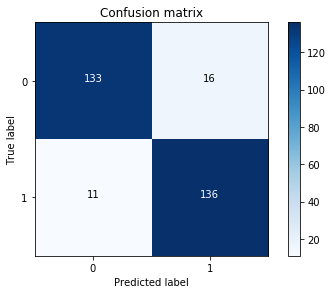

In [13]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

#### So, the model is offering an 92.5% recall accuracy on the generalised unseen data (test set). Not a bad percentage to be the first try. However, remember this is a 92.5% recall accuracy measure on the undersampled test set.

### Being happy with this result, let's apply the model we fitted and test it on the whole data.

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:  0.9115646258503401


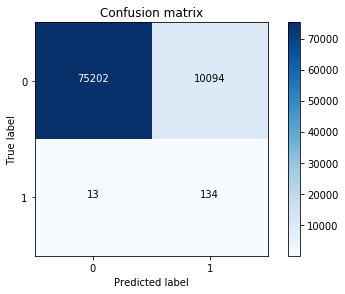

In [14]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

### Still a very decent recall accuracy when applying it to a much larger and skewed dataset! 

#### We can start to be happy with how initial approach is working.

### Plotting ROC curve and Precision-Recall curve.

- I find precision-recall curve much more convenient in this case as our problems relies on the "positive" class being more interesting than the negative class, but as we have calculated the recall precision, I am not going to plot the precision recall curves yet.

- AUC and ROC curve are also interesting to check if the model is also predicting as a whole correctly and not making many errors

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


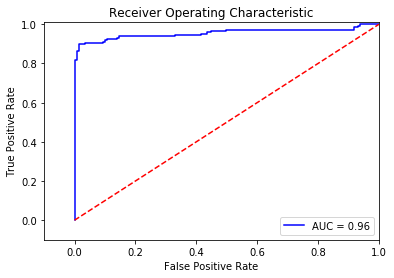

In [15]:
# ROC CURVE
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### An additional comment that would be interesting to do is to initialise multiple undersampled datasets and repeat the process in loop. Remember that, to create an undersample data, we randomly got records from the majority class. Even though this is a valid technique, is doesn't represent the real population, so it would be interesting to repeat the process with different undersample configurations and check if the previous chosen parameters are still the most effective. In the end, the idea is to use a wider random representation of the whole dataset and rely on the averaged best parameters.

# Logistic regression classifier - Skewed data

#### Having tested our previous approach, I find really interesting to test the same process on the skewed data. Our intuition is that skewness will introduce issues difficult to capture, and therefore, provide a less effective algorithm.
- To be fair, taking into account the fact that the train and test datasets are substantially bigger than the undersampled ones, I believe a K-fold cross validation is necessary. I guess that by splitting the data with 60% in training set, 20% cross validation and 20% test should be enough... but let's take the same approach as before (no harm on this, it's just that K-fold is computationally more expensive)

In [16]:
best_c = print_gridsearch_scores(X_train,y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:43

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:43

Best parameters set found on development set:
{'C': 10}
Grid scores on development set:
0.591 (+/-0.121) for {'C': 0.01}
0.594 (+/-0.076) for {'C': 0.1}
0.612 (+/-0.106) for {'C': 1}
0.620 (+/-0.122) for {'C': 10}
0.620 (+/-0.122) for {'C': 100}


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:  0.6190476190476191


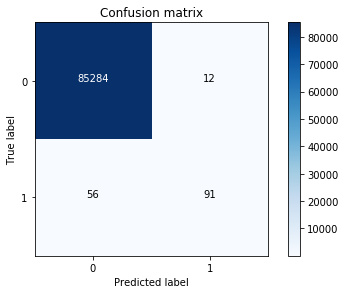

In [17]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Before continuing... changing classification threshold.

#### We have seen that by undersampling the data, our algorithm does a much better job at detecting fraud. I wanted also to show how can we tweak our final classification by changing the thresold.
- Initially, you build the classification model and then you predict unseen data using it.
- We previously used the "predict()" method to decided whether a record should belong to "1" or "0". 
- There is another method "predict_proba()".
    - This method returns the probabilities for each class. The idea is that by changing the threshold to assign a record to class 1, we can control precision and recall.
    
#### Let's check this using the undersampled data (best C_param = 0.01)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset for threshold 0.1: 1.0
Recall metric in the testing dataset for threshold 0.2: 1.0
Recall metric in the testing dataset for threshold 0.3: 1.0
Recall metric in the testing dataset for threshold 0.4: 0.9727891156462585
Recall metric in the testing dataset for threshold 0.5: 0.9251700680272109
Recall metric in the testing dataset for threshold 0.6: 0.8639455782312925
Recall metric in the testing dataset for threshold 0.7: 0.8163265306122449
Recall metric in the testing dataset for threshold 0.8: 0.7551020408163265
Recall metric in the testing dataset for threshold 0.9: 0.564625850340136


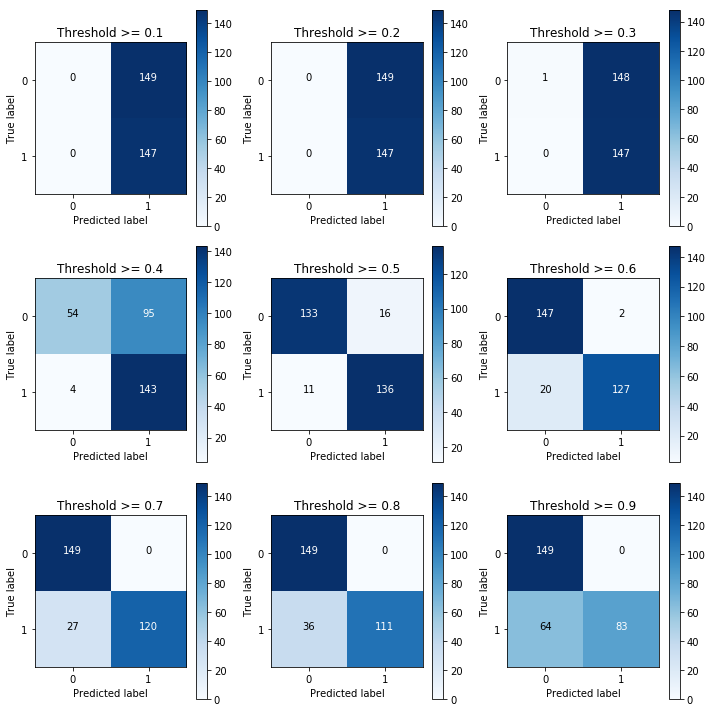

In [18]:
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset for threshold {}: {}".format(i, cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

### The pattern is very clear: the more you lower the required probability to put a certain in the class "1" category, more records will be put in that bucket.
#### This implies an increase in recall (we want all the "1"s), but at the same time, a decrease in precision (we misclassify many of the other class).
### Therefore, even though recall is our goal metric (do not miss a fraud transaction), we also want to keep the model being accurate as a whole.
- There is an option I think could be quite interesting to tackle this. We could assing cost to misclassifications, but being interested in classifying "1s" correctly, the cost for misclassifying "1s" should be bigger than "0" misclassifications. After that, the algorithm would select the threshold which minimises the total cost. A drawback I see is that we have to manually select the weight of each cost... therefore, I will leave this know as a thought.
- Going back to the threshold changing, there is an option which is the Precisio-Recall curve. By visually seeing the performance of the model depending on the threshold we choose, we can investigate a sweet spot where recall is high enough whilst keeping a high precision value.

### Investigate Precision-Recall curve and area under this curve.

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


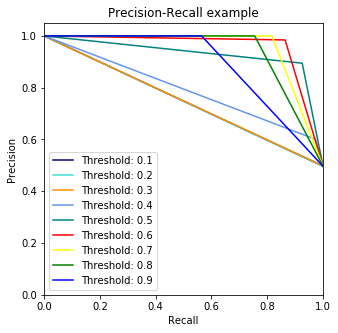

In [19]:
from itertools import cycle

lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

### Deep Learning Time

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [23]:
# change our function to have multiple hidden layers in our network
def network_builder(hidden_dimensions, input_dim):
    # create model
    model = Sequential()
    model.add(Dense(hidden_dimensions[0], input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    # add multiple hidden layers
    for dimension in hidden_dimensions[1:]:
        model.add(Dense(dimension, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
# Find the best hyper-parameter optimizing for recall
def print_gridsearch_scores_deep_learning(x_train_data,y_train_data):
    c_param_range = [0.01,0.1,1,10,100]

    clf = GridSearchCV(KerasClassifier(build_fn=network_builder, epochs=50, batch_size=128, 
                                       verbose=1, input_dim=29), 
                       {"hidden_dimensions": ([10], [10, 10, 10], [100, 10])}, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data)

    print("Best parameters set found on development set:")
    print(clf.best_params_)

    print("Grid scores on development set:")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


In [25]:
print_gridsearch_scores_deep_learning(X_train_undersample, y_train_undersample)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
550/550 [==============================] - 0s 745us/step - loss: 0.6957 - acc: 0.5527
Epoch 2/50
550/550 [==============================] - 0s 42us/step - loss: 0.6804 - acc: 0.7418
Epoch 3/50
550/550 [==============================] - 0s 58us/step - loss: 0.6638 - acc: 0.7455
Epoch 4/50
550/550 [==============================] - 0s 36us/step - loss: 0.6456 - acc: 0.7691
Epoch 5/50
550/550 [==============================] - 0s 77us/step - loss: 0.6257 - acc: 0.7945
Epoch 6/50
550/550 [==============================] - 0s 26us/step - loss: 0.6047 - acc: 0.8200
Epoch 7/50
550/550 [==============================] - 0s 55us/step - loss: 0.5821 - acc: 0.8418
Epoch 8/50
550/550 [==============================] - 0s 64us/step - loss: 0.5605 - acc: 0.8600
Epoch 9/50
550/550 [==============================] - 0s 43us/step - loss: 0.5395 - acc: 0.8818
Epoch 10/50
550

550/550 [==============================] - 0s 58us/step - loss: 0.3506 - acc: 0.9309
Epoch 29/50
550/550 [==============================] - 0s 57us/step - loss: 0.3450 - acc: 0.9327
Epoch 30/50
550/550 [==============================] - 0s 39us/step - loss: 0.3395 - acc: 0.9345
Epoch 31/50
550/550 [==============================] - 0s 44us/step - loss: 0.3340 - acc: 0.9382
Epoch 32/50
550/550 [==============================] - 0s 38us/step - loss: 0.3286 - acc: 0.9382
Epoch 33/50
550/550 [==============================] - 0s 47us/step - loss: 0.3232 - acc: 0.9400
Epoch 34/50
550/550 [==============================] - 0s 41us/step - loss: 0.3180 - acc: 0.9418
Epoch 35/50
550/550 [==============================] - 0s 44us/step - loss: 0.3127 - acc: 0.9418
Epoch 36/50
550/550 [==============================] - 0s 28us/step - loss: 0.3077 - acc: 0.9436
Epoch 37/50
550/550 [==============================] - 0s 34us/step - loss: 0.3025 - acc: 0.9455
Epoch 38/50
550/550 [=====================

551/551 [==============================] - 0s 46us/step - loss: 0.4935 - acc: 0.8221
Epoch 11/50
551/551 [==============================] - 0s 45us/step - loss: 0.4811 - acc: 0.8421
Epoch 12/50
551/551 [==============================] - 0s 41us/step - loss: 0.4699 - acc: 0.8494
Epoch 13/50
551/551 [==============================] - 0s 42us/step - loss: 0.4598 - acc: 0.8603
Epoch 14/50
551/551 [==============================] - 0s 51us/step - loss: 0.4506 - acc: 0.8711
Epoch 15/50
551/551 [==============================] - 0s 18us/step - loss: 0.4420 - acc: 0.8748
Epoch 16/50
551/551 [==============================] - 0s 68us/step - loss: 0.4338 - acc: 0.8766
Epoch 17/50
551/551 [==============================] - 0s 18us/step - loss: 0.4263 - acc: 0.8857
Epoch 18/50
551/551 [==============================] - 0s 50us/step - loss: 0.4190 - acc: 0.8875
Epoch 19/50
551/551 [==============================] - 0s 38us/step - loss: 0.4120 - acc: 0.8947
Epoch 20/50
551/551 [=====================

551/551 [==============================] - 0s 61us/step - loss: 0.2530 - acc: 0.9401
Epoch 44/50
551/551 [==============================] - 0s 39us/step - loss: 0.2483 - acc: 0.9401
Epoch 45/50
551/551 [==============================] - 0s 58us/step - loss: 0.2438 - acc: 0.9401
Epoch 46/50
551/551 [==============================] - 0s 44us/step - loss: 0.2394 - acc: 0.9401
Epoch 47/50
551/551 [==============================] - 0s 60us/step - loss: 0.2352 - acc: 0.9401
Epoch 48/50
551/551 [==============================] - 0s 31us/step - loss: 0.2311 - acc: 0.9401
Epoch 49/50
551/551 [==============================] - 0s 56us/step - loss: 0.2272 - acc: 0.9419
Epoch 50/50
551/551 [==============================] - 0s 18us/step
Epoch 1/50
550/550 [==============================] - 1s 2ms/step - loss: 0.6928 - acc: 0.7000
Epoch 2/50
550/550 [==============================] - 0s 62us/step - loss: 0.6922 - acc: 0.8836
Epoch 3/50
550/550 [==============================] - 0s 56us/step - loss:

550/550 [==============================] - 0s 52us/step - loss: 0.3335 - acc: 0.9473
Epoch 26/50
550/550 [==============================] - 0s 75us/step - loss: 0.3240 - acc: 0.9491
Epoch 27/50
550/550 [==============================] - 0s 34us/step - loss: 0.3138 - acc: 0.9491
Epoch 28/50
550/550 [==============================] - 0s 61us/step - loss: 0.3039 - acc: 0.9455
Epoch 29/50
550/550 [==============================] - 0s 44us/step - loss: 0.2931 - acc: 0.9455
Epoch 30/50
550/550 [==============================] - 0s 56us/step - loss: 0.2823 - acc: 0.9473
Epoch 31/50
550/550 [==============================] - 0s 58us/step - loss: 0.2715 - acc: 0.9473
Epoch 32/50
550/550 [==============================] - 0s 56us/step - loss: 0.2608 - acc: 0.9473
Epoch 33/50
550/550 [==============================] - 0s 53us/step - loss: 0.2497 - acc: 0.9491
Epoch 34/50
550/550 [==============================] - 0s 43us/step - loss: 0.2386 - acc: 0.9491
Epoch 35/50
550/550 [=====================

551/551 [==============================] - 0s 68us/step - loss: 0.6879 - acc: 0.7604
Epoch 8/50
551/551 [==============================] - 0s 48us/step - loss: 0.6850 - acc: 0.8439
Epoch 9/50
551/551 [==============================] - 0s 54us/step - loss: 0.6810 - acc: 0.8929
Epoch 10/50
551/551 [==============================] - 0s 77us/step - loss: 0.6755 - acc: 0.8947
Epoch 11/50
551/551 [==============================] - 0s 71us/step - loss: 0.6677 - acc: 0.9056
Epoch 12/50
551/551 [==============================] - 0s 42us/step - loss: 0.6573 - acc: 0.9093
Epoch 13/50
551/551 [==============================] - 0s 68us/step - loss: 0.6437 - acc: 0.9111
Epoch 14/50
551/551 [==============================] - 0s 28us/step - loss: 0.6261 - acc: 0.9111
Epoch 15/50
551/551 [==============================] - 0s 74us/step - loss: 0.6039 - acc: 0.9129
Epoch 16/50
551/551 [==============================] - 0s 45us/step - loss: 0.5785 - acc: 0.9129
Epoch 17/50
551/551 [=======================

551/551 [==============================] - 0s 65us/step - loss: 0.1400 - acc: 0.9528
Epoch 40/50
551/551 [==============================] - ETA: 0s - loss: 0.1473 - acc: 0.945 - 0s 42us/step - loss: 0.1367 - acc: 0.9528
Epoch 41/50
551/551 [==============================] - 0s 54us/step - loss: 0.1339 - acc: 0.9528
Epoch 42/50
551/551 [==============================] - 0s 43us/step - loss: 0.1311 - acc: 0.9528
Epoch 43/50
551/551 [==============================] - 0s 49us/step - loss: 0.1287 - acc: 0.9546
Epoch 44/50
551/551 [==============================] - 0s 82us/step - loss: 0.1265 - acc: 0.9546
Epoch 45/50
551/551 [==============================] - 0s 22us/step - loss: 0.1247 - acc: 0.9564
Epoch 46/50
551/551 [==============================] - 0s 72us/step - loss: 0.1230 - acc: 0.9564
Epoch 47/50
551/551 [==============================] - 0s 58us/step - loss: 0.1213 - acc: 0.9601
Epoch 48/50
551/551 [==============================] - 0s 59us/step - loss: 0.1196 - acc: 0.9601
Epoc

550/550 [==============================] - 0s 58us/step - loss: 0.2206 - acc: 0.9509
Epoch 21/50
550/550 [==============================] - 0s 47us/step - loss: 0.2016 - acc: 0.9491
Epoch 22/50
550/550 [==============================] - 0s 49us/step - loss: 0.1842 - acc: 0.9509
Epoch 23/50
550/550 [==============================] - 0s 84us/step - loss: 0.1692 - acc: 0.9491
Epoch 24/50
550/550 [==============================] - 0s 68us/step - loss: 0.1560 - acc: 0.9491
Epoch 25/50
550/550 [==============================] - 0s 58us/step - loss: 0.1451 - acc: 0.9509
Epoch 26/50
550/550 [==============================] - 0s 80us/step - loss: 0.1357 - acc: 0.9509
Epoch 27/50
550/550 [==============================] - 0s 66us/step - loss: 0.1281 - acc: 0.9545
Epoch 28/50
550/550 [==============================] - 0s 41us/step - loss: 0.1216 - acc: 0.9564
Epoch 29/50
550/550 [==============================] - 0s 71us/step - loss: 0.1162 - acc: 0.9582
Epoch 30/50
550/550 [=====================

551/551 [==============================] - 0s 87us/step - loss: 0.6630 - acc: 0.7132
Epoch 3/50
551/551 [==============================] - 0s 81us/step - loss: 0.6310 - acc: 0.7532
Epoch 4/50
551/551 [==============================] - 0s 62us/step - loss: 0.5931 - acc: 0.7967
Epoch 5/50
551/551 [==============================] - 0s 53us/step - loss: 0.5529 - acc: 0.8312
Epoch 6/50
551/551 [==============================] - 0s 70us/step - loss: 0.5144 - acc: 0.8512
Epoch 7/50
551/551 [==============================] - 0s 54us/step - loss: 0.4804 - acc: 0.8766
Epoch 8/50
551/551 [==============================] - 0s 68us/step - loss: 0.4515 - acc: 0.8911
Epoch 9/50
551/551 [==============================] - 0s 64us/step - loss: 0.4287 - acc: 0.9111
Epoch 10/50
551/551 [==============================] - 0s 71us/step - loss: 0.4088 - acc: 0.9183
Epoch 11/50
551/551 [==============================] - 0s 67us/step - loss: 0.3905 - acc: 0.9274
Epoch 12/50
551/551 [============================

551/551 [==============================] - 0s 66us/step - loss: 0.1025 - acc: 0.9637
Epoch 36/50
551/551 [==============================] - 0s 45us/step - loss: 0.0999 - acc: 0.9655
Epoch 37/50
551/551 [==============================] - 0s 69us/step - loss: 0.0976 - acc: 0.9655
Epoch 38/50
551/551 [==============================] - 0s 81us/step - loss: 0.0954 - acc: 0.9655
Epoch 39/50
551/551 [==============================] - 0s 43us/step - loss: 0.0933 - acc: 0.9655
Epoch 40/50
551/551 [==============================] - 0s 55us/step - loss: 0.0913 - acc: 0.9655
Epoch 41/50
551/551 [==============================] - 0s 71us/step - loss: 0.0893 - acc: 0.9655
Epoch 42/50
551/551 [==============================] - 0s 44us/step - loss: 0.0876 - acc: 0.9691
Epoch 43/50
551/551 [==============================] - 0s 71us/step - loss: 0.0856 - acc: 0.9728
Epoch 44/50
551/551 [==============================] - 0s 64us/step - loss: 0.0841 - acc: 0.9710
Epoch 45/50
551/551 [=====================

Recall metric in the testing dataset:  0.9183673469387755


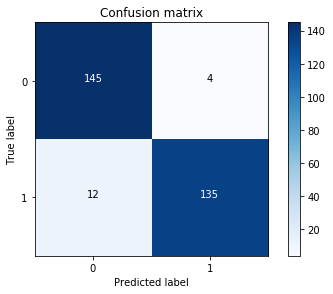

In [26]:
# Use this hidden_dimensions paraemeter to build the final model with the whole training dataset and 
# predict the classes in the test dataset
k = KerasClassifier(build_fn=network_builder, epochs=50, batch_size=128, 
                     hidden_dimensions=[100, 10], verbose=0, input_dim=29)
k.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = k.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Recall metric in the testing dataset:  0.9319727891156463


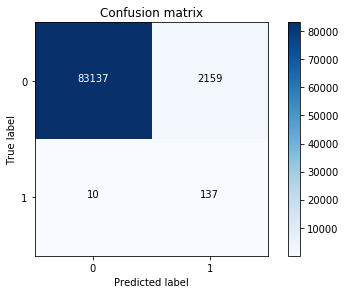

In [27]:
y_pred = k.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()